In [1]:
import sys
import os

import pandas as pd
import matplotlib.pyplot as plt

import textwrap as tw
import datetime
from datetime import timedelta

# preamble for jupyter notebook and django
import django
import platform

if platform.node() == "srv-mcc-apsis":
    #sys.path.append("/home/galm/software/django/tmv/BasicBrowser/")
    sys.path.append('/home/leey/tmv/BasicBrowser/')
else:
    # local paths
    sys.path.append('/home/leey/Documents/Data/tmv/BasicBrowser/')

os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

# import from appended path
import scoping.models as sm
import twitter.models as tm
from tmv_app.models import *

import cities.models as cmodels

from django.contrib.auth.models import User
from django.core import serializers
from django.db.models import Sum, Count, Q
from django.db.models.fields import DateField
from django.db.models.functions import Cast

In [2]:
import re
from collections import Counter

In [4]:
# Style
import seaborn as sns
sns.set_style('whitegrid')

---

### getting data

In [6]:
p = sm.Project.objects.get(pk=196)

In [7]:
end_date = datetime.datetime.strptime('2019-09-30-+0000', '%Y-%m-%d-%z')

In [8]:
searches = tm.TwitterSearch.objects.filter(project_list=p)

In [9]:
kohle_ts = tm.TwitterSearch.objects.get(pk=1)

#klimaschutz, #hambacherforst, #hambibleibt, #endcoal, #fridaysforfuture, #klima, #klimawandel, #endegelaende

In [10]:
# Q lookup must precede any keyword argument
query1 = tm.Status.objects.filter(
    Q(text__icontains = '#klimaschutz') |
    Q(text__icontains = '#hambacherforst') |
    Q(text__icontains = '#hambibleibt') |
    Q(text__icontains = '#endcoal') |
    Q(text__icontains = '#fridaysforfuture') |
    Q(text__icontains = '#klimawandel') |
    Q(text__icontains = '#klima') |
    Q(text__icontains = '#endegelaende') 
).filter(
    searches=kohle_ts
).filter(
    created_at__lte=end_date
)

query1.count()

45211

In [11]:
query2 = tm.Status.objects.filter(
    searches__in=searches,
    text__isnull=False,
    retweeted_status__isnull=True,
    created_at__lte=end_date
)
query2.count()

184960

In [12]:
# taking the union of both querysets
qcomb = query1 | query2
qcomb.count()

230171

---

### How many tweets added?

In [13]:
baseline_terms = ['Klima', 'Erderwärmung', 'globale Erwärmung','Treibhauseffekt']
baseline = tm.TwitterSearch.objects.filter(
    Q(string='Klima') |
    Q(string='Erderwärmung') |
    Q(string='globale Erwärmung') |
    Q(string='Treibhauseffekt')
)

In [14]:
baseline_tweets = tm.Status.objects.filter(
    searches__in=baseline,
    text__isnull=False,
    retweeted_status__isnull=True,
    #created_at__lte=end_date
)

In [15]:
new_date = datetime.datetime.strptime('2019-02-14-+0000', '%Y-%m-%d-%z')

In [16]:
newly_fetched = baseline_tweets.filter(fetched__gte=new_date)

In [17]:
print(len(newly_fetched))

2165453


---

### Tweet Frequency

In [18]:
byday = qcomb.annotate(
            date_only=Cast('created_at', DateField())
        ).values('date_only').annotate(
            n = Count('pk')
        ).order_by('date_only')

In [19]:
df_byday = pd.DataFrame.from_dict(list(byday))

In [20]:
df_byday['date_only'] = pd.to_datetime(df_byday['date_only'])

In [21]:
df_byday.head()

,date_only,n
0,2009-11-16,1
1,2009-11-22,1
2,2009-11-23,1
3,2009-11-26,1
4,2009-12-01,1


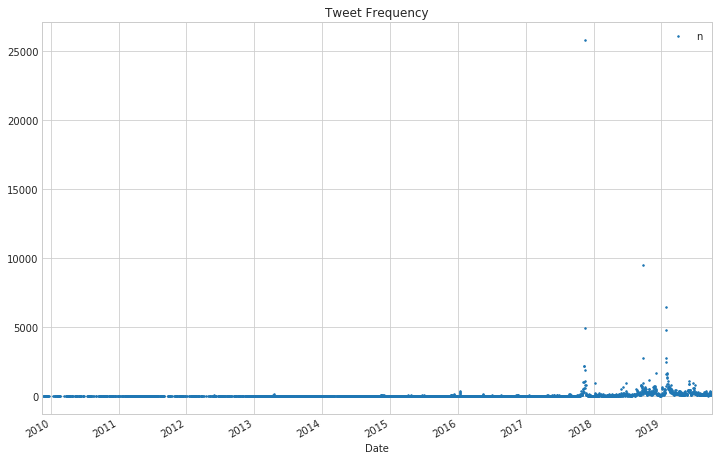

In [26]:
fig, ax = plt.subplots(figsize=(12,8))
df_byday.plot('date_only','n', style=".", ax=ax, ms=3)
ax.set(xlabel='Date', title='Tweet Frequency')
plt.show()
#fig.savefig('plots/tweet_frequency.png',dpi=300)

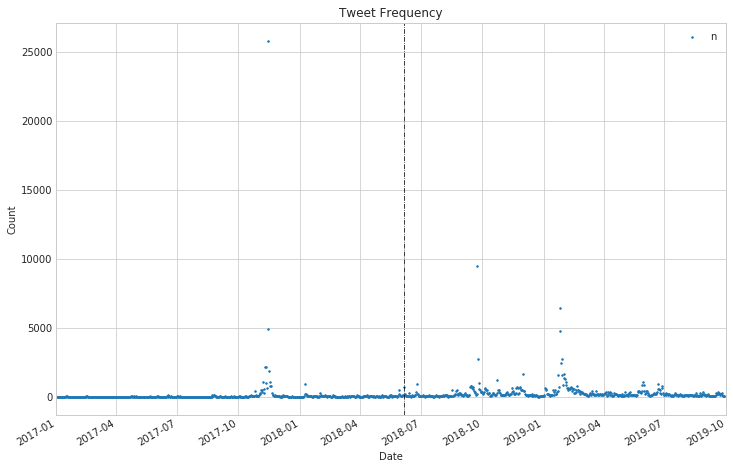

In [29]:
fig, ax = plt.subplots(figsize=(12,8))
df_byday.plot('date_only','n', style=".", ax=ax, ms=3)
ax.set(xlim=(datetime.datetime.strptime('2017-01-01', '%Y-%m-%d'), datetime.datetime.strptime('2019-10-1', '%Y-%m-%d')), xlabel="Date",ylabel="Count", title="Tweet Frequency")
ax.axvline(x=(datetime.datetime.strptime('2018-06-06', '%Y-%m-%d')), ls ='-.',lw='0.75', c = 'k')
plt.show()
#fig.savefig('plots/tweet_frequency_zoom.png',dpi=300)

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))
ax.stem('date_only','n', markerfmt=' ')
ax.set(xlim=(datetime.datetime.strptime('2017-01-01', '%Y-%m-%d'), datetime.datetime.strptime('2019-12-31', '%Y-%m-%d')), xlabel="Date",ylabel="Count", title="Tweet Frequency")
ax.axvline(x=(datetime.datetime.strptime('2018-06-06', '%Y-%m-%d')), ls ='-.',lw='0.75', c = 'k')
plt.show()

In [30]:
df_byday.sort_values(by='n',ascending=False)[:20]

,date_only,n
2053,2017-11-14,25795
2367,2018-09-24,9466
2491,2019-01-26,6473
2054,2017-11-15,4922
2490,2019-01-25,4773
2368,2018-09-25,2788
2493,2019-01-28,2762
2492,2019-01-27,2484
2051,2017-11-12,2165
2049,2017-11-10,2151


---

### Results from "kohle" TwitterSearch object

In [59]:
p1 = sm.Project.objects.get(pk=134)

In [67]:
searches = tm.TwitterSearch.objects.filter(project=p1)
searches

<QuerySet [<TwitterSearch: TwitterSearch object (1)>, <TwitterSearch: TwitterSearch object (2)>, <TwitterSearch: TwitterSearch object (3)>, <TwitterSearch: TwitterSearch object (4)>]>

In [62]:
for i in searches:
    print(i.string)

kohle
Kohlekommission
coal
@badulrichmartha


In [64]:
searches[0].pk

1

In [68]:
kt1 = tm.Status.objects.filter(
    searches=kohle_ts,
    text__isnull=False,
    retweeted_status__isnull=True,
    created_at__lte=end_date
).values_list('text',flat=True)

In [69]:
# Hashtags for all coal
taglist_kohle_ts = []
regstrip = re.compile('\W\s')
for x in kt1:
    match = re.findall('\#.+?\s', x, re.MULTILINE)
    for m in match:
        m1 = regstrip.sub("",m)
        taglist_kohle_ts.append(m1.strip().lower())

In [70]:
taglist_kohle_ts_df = pd.DataFrame(Counter(taglist_kohle_ts).keys(), columns=['Hashtag'])
taglist_kohle_ts_df['Count'] = list(Counter(taglist_kohle_ts).values())

In [71]:
taglist_kohle_ts_df[taglist_kohle_ts_df.Count > 100].sort_values(by=['Count'], ascending=False)

,Hashtag,Count
23,#kohle,31325
4,#kohlefrei,18037
41,#kohlekommission,15327
81,#kohleausstieg,12367
39,#energiewende,6783
22,#klimaschutz,5836
8,#rwe,5314
34,#hambacherforst,5160
9,#hambibleibt,4131
24,#endcoal,3285


terms to take: #klimaschutz, #hambacherforst, #hambibleibt, #endcoal, #fridaysforfuture, #klima, #klimawandel, #endegelaende

In [72]:
taglist_kohle_ts_df.to_csv('taglist_kohle_ts_df.csv')